In [127]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [128]:
datam = pd.read_csv("../Data/monthly_data.csv")
# convert DateTime column into datetime format
datam["datetime"] = pd.to_datetime(datam['datetime'])
# set DateTime as index
datam.set_index("datetime", inplace=True)
datam.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2012-01-31 to 2019-11-30
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suction_tension (20cm)   95 non-null     float64
 1   suction_tension (40cm)   95 non-null     float64
 2   suction_tension (70cm)   95 non-null     float64
 3   water_temperature        95 non-null     float64
 4   barometric_pressure_qfe  95 non-null     float64
 5   dew_point                95 non-null     float64
 6   water_level              95 non-null     float64
 7   inflow_linth (m3/s)      95 non-null     float64
 8   outflow_limmat (m3/s)    95 non-null     float64
 9   precipitation (mm)       95 non-null     float64
 10  Evapotranspiration (mm)  95 non-null     float64
 11  change_rate              94 non-null     float64
dtypes: float64(12)
memory usage: 9.6 KB


In [129]:
water = datam[["water_level"]]
water

,water_level
datetime,
2012-01-31,405.852715
2012-02-29,405.714322
2012-03-31,405.729378
2012-04-30,405.782916
2012-05-31,405.838784
...,...
2019-07-31,406.020067
2019-08-31,406.072119
2019-09-30,406.036799


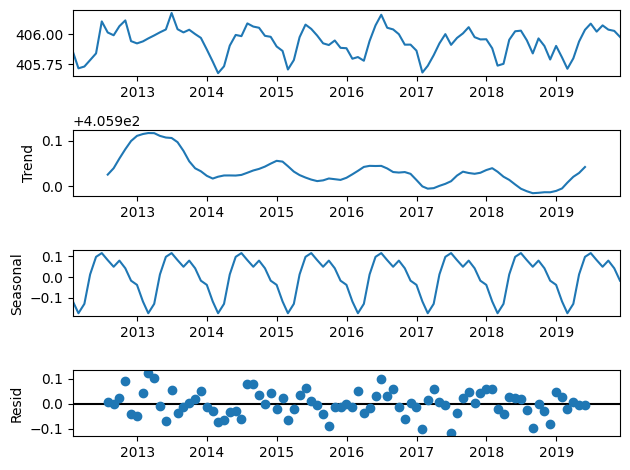

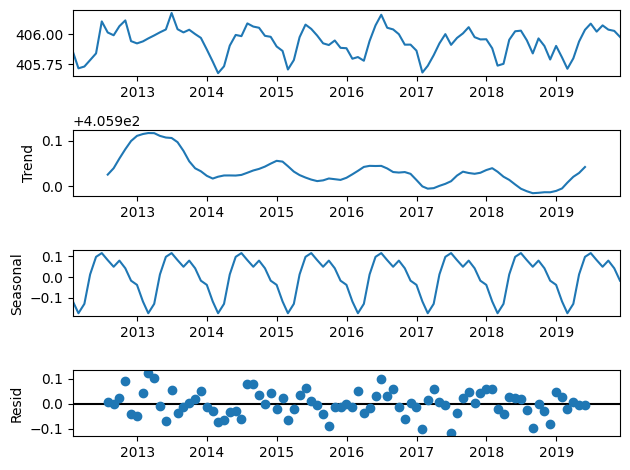

In [130]:

result = seasonal_decompose(water)
result.plot()

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


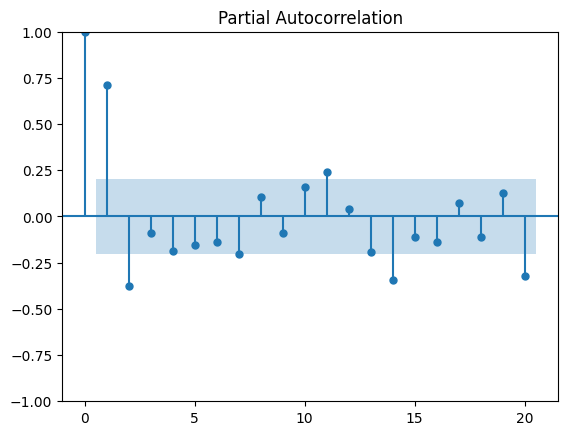

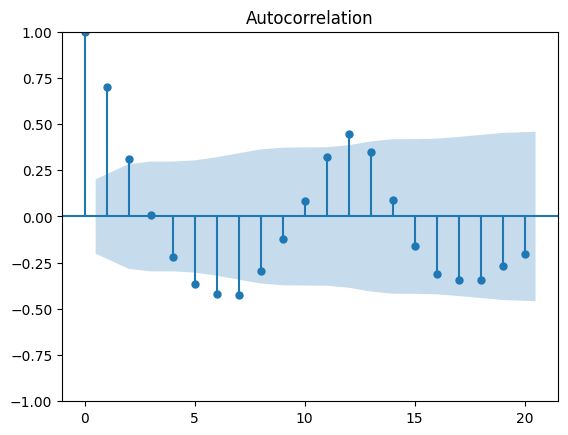

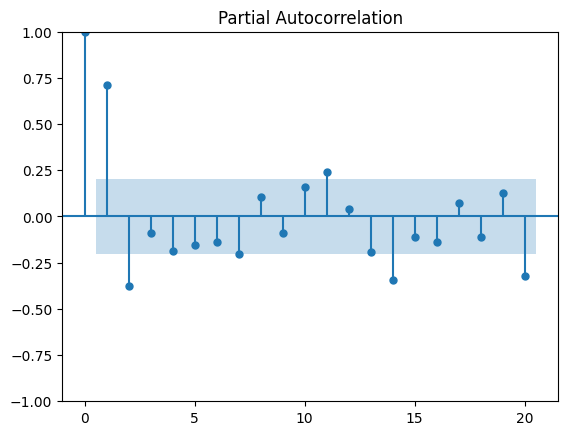

In [131]:
plot_acf(water)
plot_pacf(water)

In [132]:
# check for stationarity with the ADF test
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(water)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -2.229628828447892
ADF p-values: 0.1956681472226814
ADF number of lags used: 10
ADF number of observations: 84
ADF critical values: {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
ADF best information criterion: -195.11819099343586


<AxesSubplot: xlabel='datetime'>

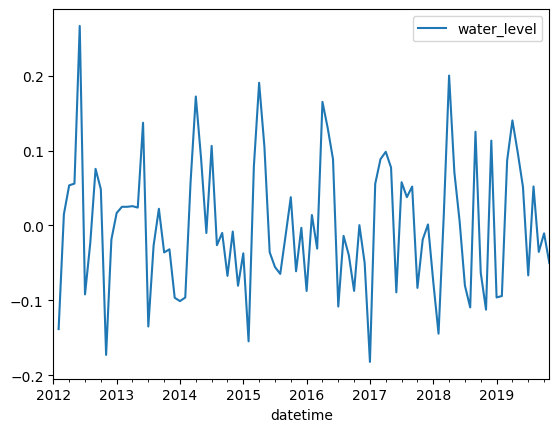

In [133]:
# differencing water level data to make it stationary 
prev_co2_value = water.shift()
differenced_co2 = water - prev_co2_value
differenced_co2.plot()

In [134]:
# ADF test on differenced data
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_co2.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -3.1463403734040645
ADF p-values: 0.023308502613789233
ADF number of lags used: 12
ADF number of observations: 81
ADF critical values: {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
ADF best information criterion: -189.12927178184964


In [135]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [136]:
train, test = train_test_split(differenced_co2, train_size=72)

In [102]:
model = pm.auto_arima(train.dropna(), seasonal=True, m=12)
preds = model.predict(test.shape[0])

In [103]:
model

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [138]:
from statsmodels.tsa.arima.model import ARIMA
model_manual = ARIMA(water, order=(3,1,1), seasonal_order=(3,1,1,12))
model_manual_fit = model_manual.fit()
preds_manual = model_manual_fit.forecast(len(test))

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


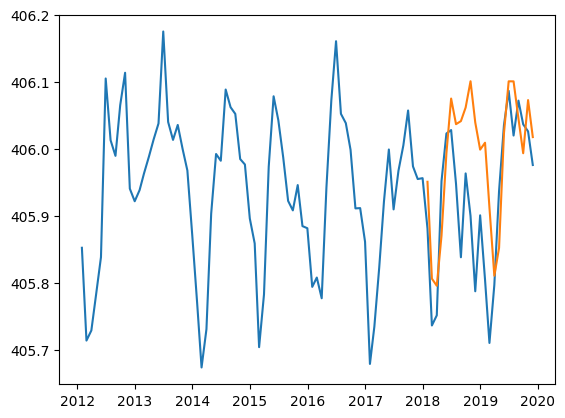

In [139]:
plt.plot(water.index, water)
plt.plot(water.index[72:], preds_manual)
plt.show()

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -1.088102
         Iterations: 11
         Function evaluations: 1042


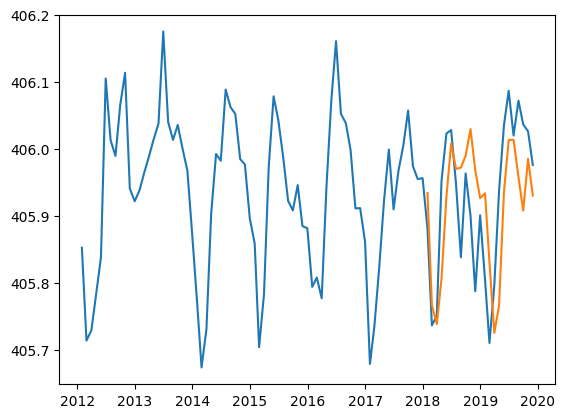

In [152]:
# model with Sarimax
import statsmodels.api as sm
model_max = sm.tsa.statespace.SARIMAX(water, order=(2,1,1), seasonal_order=(2,1,1,12)).fit(max_iter=46, method='powell')
# predicting with model
preds_max = model_max.forecast(len(test))
# plotting prediction and actual values
plt.plot(water.index, water)
plt.plot(water.index[72:], preds_max)
plt.show()

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


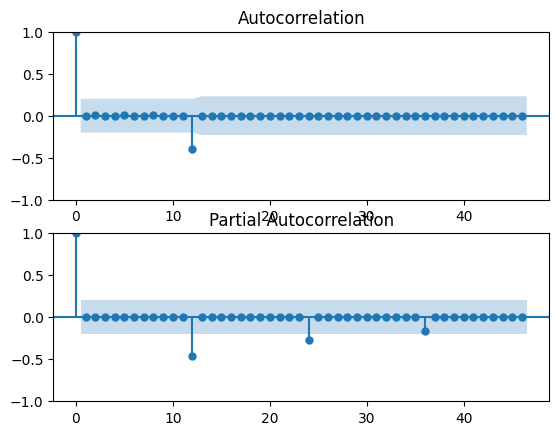

In [151]:
# plot ACF and PACF curve for residuals of SARIMAX model

res = model_max.resid

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=46, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=46, ax=ax[1])
plt.show()

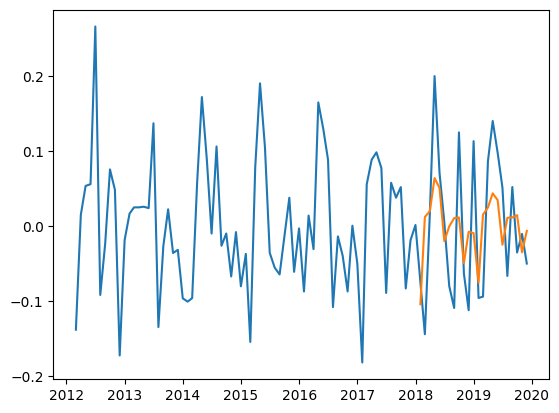

In [106]:
#x = np.arange(y.shape[0])
plt.plot(water.index, differenced_co2)
plt.plot(water.index[72:], preds)
plt.show()

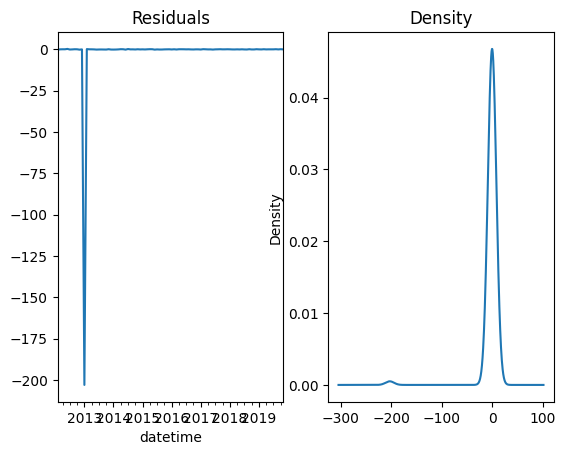

In [140]:
residuals = model_manual_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()


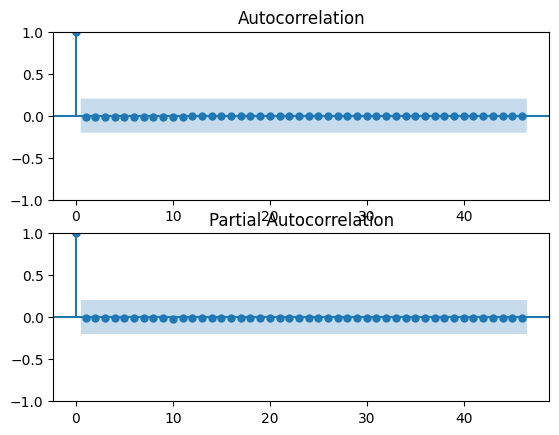

In [143]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(residuals, lags=46, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=46, ax=ax[1])
plt.show()